# Topic Modelling with LDA
[Kaggle](https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda)

## Imports

In [171]:
import numpy as np
import pandas as pd
# from IPython.display import display
# from tqdm import tqdm
from collections import Counter
# import ast

import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
# import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
# from textblob import TextBlob
# import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.manifold import TSNE

# from bokeh.plotting import figure, output_file, show
# from bokeh.models import Label
# from bokeh.io import output_notebook
# output_notebook()

# %matplotlib inline

## Read in the data

In [172]:
reports = pd.read_csv('reports_joined.csv')
reports

,Unnamed: 0,Unnamed: 0.1,filepath,number_of_pages,lang,text
0,0,0,./reports/scraped/full/mtu.pdf,226,deu,Aero Engines\n\nMTU\nSS\n\nGeschäftsbericht\n\...
1,1,1,./reports/scraped/full/henkel.pdf,219,deu,\n Henkel Nachhaltigkeitsbericht 2020\n\n02\n\...
2,2,3,./reports/scraped/full/dpdhl.pdf,2,deu,\n\nNACHHALTIGKEITSFAHRPLAN\nZAHLEN & FAKTEN\n...
3,3,5,./reports/scraped/full/daimler.pdf,205,deu,DAIMLER\n\n\n\n\n\nNachhaltigkeitsbericht 2019...
4,4,14,./reports/scraped/full/deutsche-boerse.pdf,7,deu,\n\n\nDEUTSCHE BÖRSE\nit GROUP\n\n\n\nKlimastr...
5,5,13,./reports/scraped/full/infineon.pdf,68,deu,\n\nNachhaltigkeit bei Infineon\nIn Ergänzung ...
6,6,11,./reports/scraped/full/heidelbergcement.pdf,96,deu,\n\n\n\n\nii)\n23\n|\n39\n55\n68\nrZ\nne\n\n\n...
7,0,16,./reports/scraped/full/adidas-group.pdf,84,eng,\n\nADIDAS\nSUSTAINABILITY\nPROGRESS\nREPORT\n...
8,1,15,./reports/scraped/full/eon.pdf,3,eng,Slavery & Human\nTrafficking Statement\n\nE.ON...
9,2,12,./reports/scraped/full/siemens-energy.pdf,80,eng,SIEMENS\nCialcieys\n\nSustainability Report 20...


## Transform
- exclude german texts
- remove linebreaks
- turn words to lowercase

In [173]:
# exclude german texts
reports = reports[reports['lang'] == 'eng']
reports.reset_index(drop=True, inplace=True)
reports

,Unnamed: 0,Unnamed: 0.1,filepath,number_of_pages,lang,text
0,0,16,./reports/scraped/full/adidas-group.pdf,84,eng,\n\nADIDAS\nSUSTAINABILITY\nPROGRESS\nREPORT\n...
1,1,15,./reports/scraped/full/eon.pdf,3,eng,Slavery & Human\nTrafficking Statement\n\nE.ON...
2,2,12,./reports/scraped/full/siemens-energy.pdf,80,eng,SIEMENS\nCialcieys\n\nSustainability Report 20...
3,3,9,./reports/scraped/full/munichre.pdf,106,eng,-pehaaiek tre\nReport 2020\n\n\n\nMunich RE\n ...
4,4,17,./reports/scraped/full/volkswagenag.pdf,97,eng,VOLKSWAGEN\n\nAKTIENGESELLSCHAFT\n\n\n\nSUSTAI...
5,5,8,./reports/scraped/full/new.siemens.pdf,144,eng,Sustainability\ninformation\n2020\n\nee : 7 a\...
6,6,7,./reports/scraped/full/freseniusmedicalcare.pdf,24,eng,“Se” FRESENIUS\nY MEDICAL CARE\n\n20\n\nNON-FI...
7,7,6,./reports/scraped/full/group.pdf,139,eng,\n\n\n\nNew ways for\n\na sustainable future.\...
8,8,4,./reports/scraped/full/fresenius.pdf,338,eng,"MediaHub Group in figures Targets, results, an..."
9,9,2,./reports/scraped/full/allianz.pdf,102,eng,|COLLABORATING FOR\nA SUSTAINABLE FUTURE\n\nes...


In [174]:
# remove linebreaks
reports['text'] = reports['text'].str.replace(r'\s+',' ', regex=True)

<ipython-input-174-007b9df3d4b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reports['text'] = reports['text'].str.replace(r'\s+',' ', regex=True)


In [175]:
# turn words to lowercase
reports.text = reports.text.str.lower()
reports.head()

/home/fiete/Documents/studium/fuehrung_und_nachhaltigkeit/nlp_env/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Unnamed: 0,Unnamed: 0.1,filepath,number_of_pages,lang,text
0,0,16,./reports/scraped/full/adidas-group.pdf,84,eng,adidas sustainability progress report calling...
1,1,15,./reports/scraped/full/eon.pdf,3,eng,slavery & human trafficking statement e.on's s...
2,2,12,./reports/scraped/full/siemens-energy.pdf,80,eng,siemens cialcieys sustainability report 2020 g...
3,3,9,./reports/scraped/full/munichre.pdf,106,eng,-pehaaiek tre report 2020 munich re table of c...
4,4,17,./reports/scraped/full/volkswagenag.pdf,97,eng,volkswagen aktiengesellschaft sustainability r...


In [176]:
# Define helper functions
def get_top_n_words_for_fig(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])



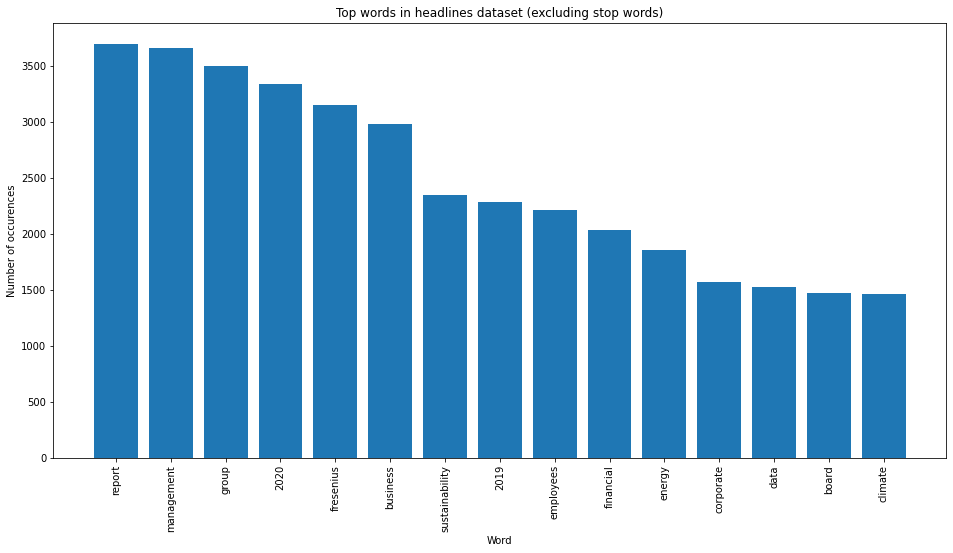

In [177]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words_for_fig(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reports[reports['lang'] == 'eng']['text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()


## Topic Modelling

In [178]:

count_vectorizer = CountVectorizer(stop_words='english') # , max_features=40000
#small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Report before vectorization: {}'.format(reports['text'][0][:500]))

document_term_matrix = count_vectorizer.fit_transform(reports['text'])

print('Headline after vectorization: \n{}'.format(document_term_matrix[0][:500]))

Report before vectorization:  adidas sustainability progress report calling all creators com neh acs) neki: maw (ene neelam mols sustainability efforts over the.years, we know lien mee hem any lee ae mum aaehwmda tes in order to tackle the big challenges we are better off when working together. for this reason, we are calling all creators, our own employees, our partners and consumers as well as suppliers to be a part of this important journey. we strive to give them the space their ideas and creative force need to improve 
Headline after vectorization: 
  (0, 2040)	112
  (0, 18083)	35
  (0, 14953)	33
  (0, 15969)	12
  (0, 3985)	3
  (0, 5585)	10
  (0, 4815)	12
  (0, 12931)	1
  (0, 1955)	1
  (0, 12942)	1
  (0, 12082)	1
  (0, 7338)	1
  (0, 12910)	1
  (0, 12579)	1
  (0, 7063)	17
  (0, 20416)	30
  (0, 11071)	5
  (0, 11507)	1
  (0, 12184)	1
  (0, 9504)	1
  (0, 11368)	4
  (0, 2126)	5
  (0, 12731)	1
  (0, 1755)	1
  (0, 18498)	2
  :	:
  (0, 20111)	1
  (0, 17744)	1
  (0, 1603)	1
  (0, 1607)	1
 

## Latent Semantic Analysis (LSA)

In [179]:
n_topics = 8
n_topics = 17
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [180]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [181]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [182]:
from scipy.sparse import csr_matrix

# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        if (isinstance(temp_vector_sum, csr_matrix)):
            temp_vector_sum = temp_vector_sum.toarray()
        elif (isinstance(temp_vector_sum, int)):
            temp_vector_sum = np.zeros((1, document_term_matrix.shape[1]))
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            #topic_words.append(the_word.encode('ascii').decode('utf-8'))
            topic_words.append(the_word)
        top_words.append(" ".join(topic_words))         
    return top_words

In [183]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  fresenius report group management 2020 business financial 2019 care consolidated
Topic 2:  siemens energy sustainability business 2020 fiscal management year environmental employees
Topic 3:  allianz sustainability esg climate business 2019 data 04 governance management
Topic 4:  études effects dumping dunckerstrabe duplicated duplicating duplication dur dura durable
Topic 5:  rwe gri report 2020 energy environmental management 103 power social
Topic 6:  group volkswagen management sustainability year business 2020 report compliance employees
Topic 7:  wohnen deutsche management climate 2020 energy gri employees sustainability responsibility
Topic 8:  études effects dumping dunckerstrabe duplicated duplicating duplication dur dura durable
Topic 9:  études effects dumping dunckerstrabe duplicated duplicating duplication dur dura durable
Topic 10:  2016 suppliers adidas water factories performance 2020 target number 2015
Topic 11:  études effects dumping dunckerstrabe duplicate